# kernel density estimation (KDE)
given a sample from a population (i.e., given data), kernel density estimation is a non-parametric technique to estimate the density of the underlying probability distribution that generated the data.

the technique is [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) because it does not assume that the distribution takes the shape of any particular (parameterized) probability distribution.

let $f(x)$ be the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) of a continuous random variable $X$. then, when we sample from this distribution, the probability that $X$ falls in an infinitesimally small interval of width $dx$ centered at $x$ is $f(x)dx$.

In typical applications, $f(x)$ is unknown, and all we have is a random sample from the distribution $f(x)$.

Say we have a random sample $x_1, x_2, ..., x_n$ drawn from the probability density $f(x)$, and we want to estimate $f(x_0)$, where $x_0$ is (probably) not in our sample. Kernel density estimation is a principled way to do this.

we are still in the domain of *statistical inference* because we are aiming to make conclusions about the distribution in the population from a random sample.

[here](https://mathisonian.github.io/kde/) is an interactive description of KDE.

In [1]:
using CSV
using DataFrames
using PyPlot
using ScikitLearn
using Statistics
using Random
using LaTeXStrings
using Printf

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

## the distribution of masses of apples on an orchard

we own an apple orchard in Oregon. we want to know the distribution of the masses of apples so we can (a) estimate our revenues and then (b) make sound investments in our orchard without taking on too much risk. it is prohibitively expensive to measure the mass of every apple, so we instead take a random sample of the apples in our orchard and record their masses. the data is in `apples.csv`.

let $M$ be the mass of an apple on our orchard, a random variable.

In [2]:
df = CSV.read("apples.csv")
first(df, 5)

,mass
,Float64
1,108.205
2,92.1145
3,107.959
4,58.8771
5,100.104


In [3]:
@printf("apple masses range from %.2f g to %.2f g", 
    minimum(df[:, :mass]), maximum(df[:, :mass]))

apple masses range from 58.88 g to 129.10 g

## histograms are not great for estimating densities

in a histogram, we divide the set of possible values of the random variable $M$ into discrete bins (usually of equal width) and count the number of samples (in this case, apples) that fall in each bin.

* the density estimate is jagged (not smooth), and the discontinuities in the density estimate are an artifact of where you choose the bins to be (centers and widths), rather than the underlying probability distribution
* the density estimate depends on where the bins start and end
* qualitative features in the data can be hidden depending on shifts in the bins, even if the bins are the same width
* as we add dimensions, the number of bins grows exponentially; thus, most bins will be empty in a higher dimensional histogram unless we have a very large number of samples

to illustrate, consider making a histogram by partitioning the apple mass interval $[0, 130]$ into 8 equal-width bins and consider shifting the bins anywhere from 0 to 50. the histogram can reveal/hide bimodality in the distribution of apple masses depending on the offset!

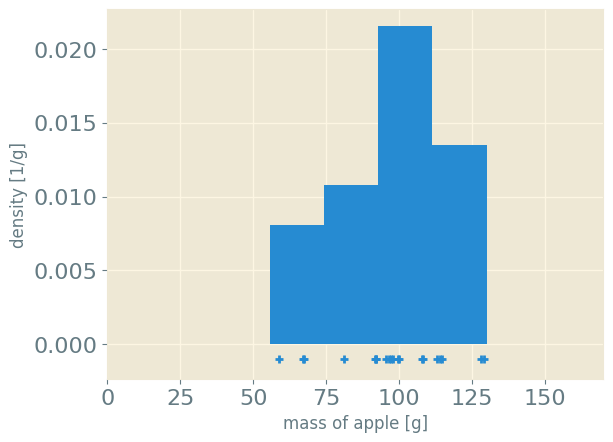

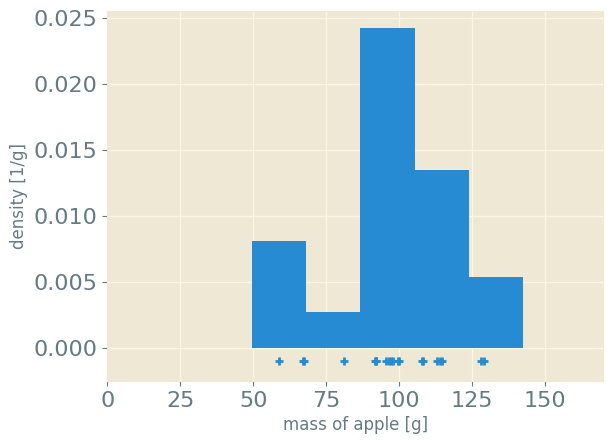

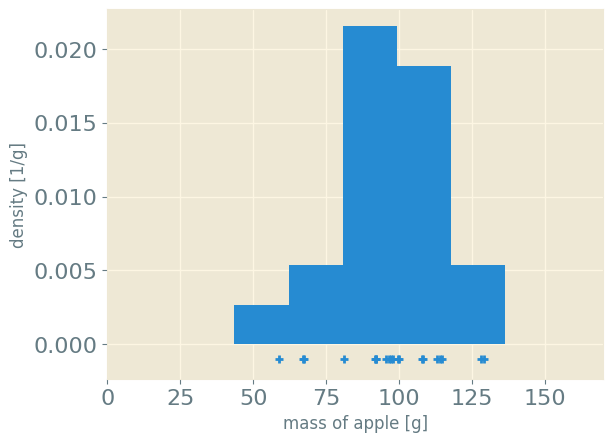

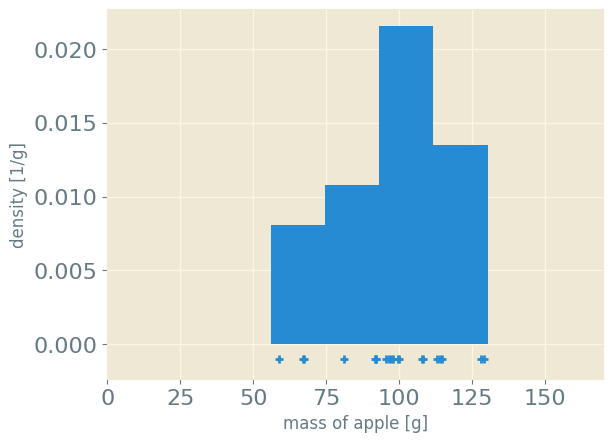

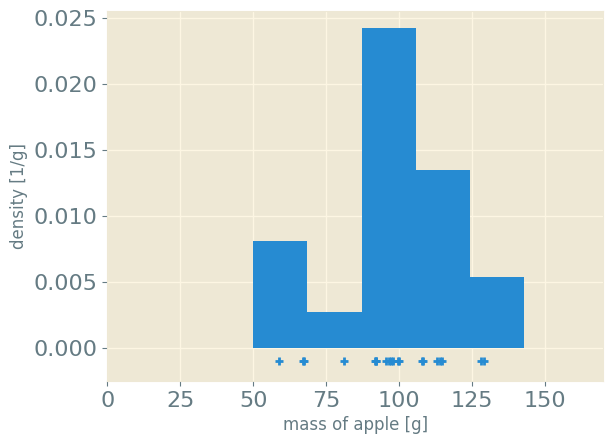

In [4]:
bins = range(0.0, stop=130.0, length=8)

offsets = range(0.0, stop=50.0, length=5)

for offset in offsets
    figure()
    hist(df[:, :mass], bins=bins .+ offset, normed=true) # normed=true important
    xlabel("mass of apple [g]")
    ylabel("density [1/g]")
    scatter(df[:, :mass], [-0.001 for i = 1:nrow(df)], marker="+")
    xlim([0, 170.0])
end

## kernel function
a kernel function $K(x_0, x_i)$ is a weighting function that assigns a weight to $x_i$ based on its distance from $x_0$. such kernel functions are typically indexed by a parameter $\lambda$ that dictates the width of the neighborhood around $x_0$ where the kernel for $x_i$ is "sizeable" (or, for some kernels, nonzero). the kernel assigns a weight to $x_i$ that decays as its distance from $x_0$ increases.

kernel properties:
* symmetry: $K(x_0, x_i)=K(x_i, x_0)$
* non-negative: $K_\lambda(x_0, x_i)\geq 0$
* like a probability density function: $\int_{-\infty}^\infty K(x_0, x_i) dx_i = 1$
* decays as $x_i$ gets far from $x_0$: $\lim_{x_i \rightarrow \pm \infty} K(x_0, x_i)=0$

**the Gaussian kernel**
\begin{equation}
K_\lambda(x_0, x_i):=\frac{1}{(2\pi\lambda^2)^{d/2}}\exp{\left(-\dfrac{||x_0-x_i||^2}{2\lambda^2}\right)}
\end{equation}
here, the bandwidth $\lambda$ of the kernel function is the variance of the Gaussian. $d$ is the dimension of the vectors $x_0$ and $x_i$.


**the Epanechnikov kernel**
\begin{equation}
K_\lambda(x_0, x_i):=\frac{3}{4\lambda}\left(1-||x_0-x_i||^2/\lambda^2\right)\mathbf{1}(||x_0-x_i||^2 < \lambda^2)
\end{equation} where $\mathbf{1}$ is the indicator function. the Epanechnikov kernel only has finite support, in contrast the Gaussian kernel.

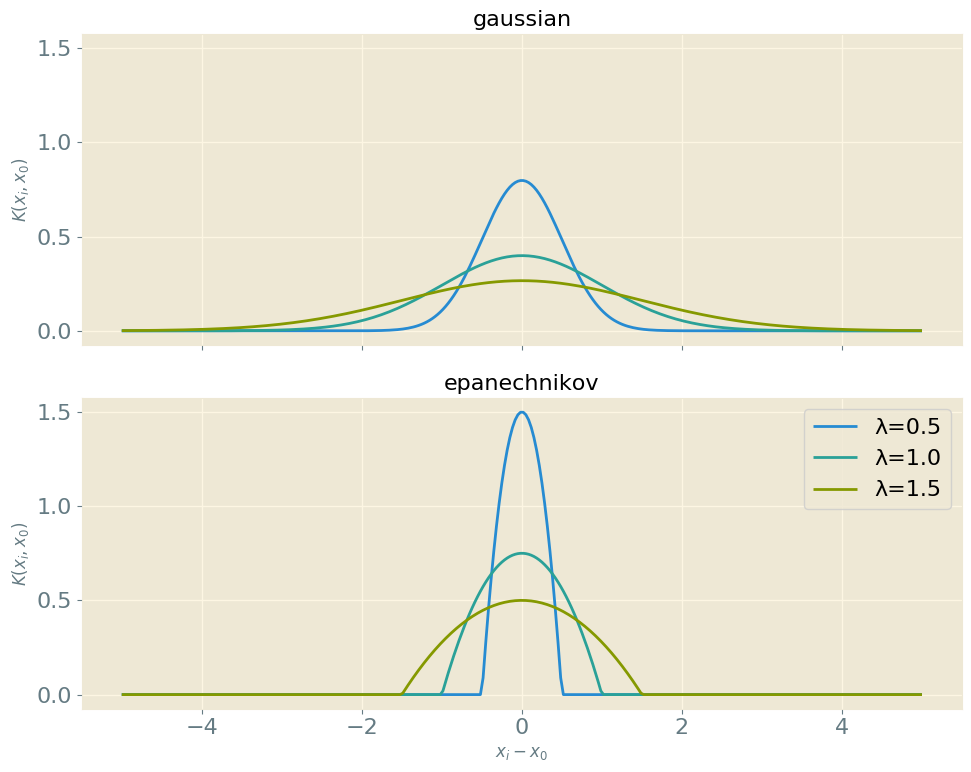

PyObject <matplotlib.legend.Legend object at 0x7f45125e8860>

In [14]:
function K(x₀::Float64, xᵢ::Float64, λ::Float64, wut_kernel::String)
    if wut_kernel == "gaussian"
        return exp(-(x₀- xᵢ) ^ 2 / (2 * λ^2)) / sqrt(2 * π * λ ^ 2)
    elseif wut_kernel == "epanechnikov"
        u = (x₀ - xᵢ) ^ 2 / λ ^ 2
        if u < 1.0
            return 3 / 4 * (1 - u) / λ
        else
            return 0.0
        end
    else # not implemented
        return NaN
    end
end

x₀ = 0.0
xᵢs = range(-5.0, stop=5.0, length=300)
λs = [0.5, 1.0, 1.5]

fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for λ in λs
    for (i, kernel_type) in enumerate(["gaussian", "epanechnikov"])
        k = [K(x₀, xᵢ, λ, kernel_type) for xᵢ in xᵢs]
        axs[i].plot(xᵢs, k, label="λ=$λ")
        axs[i].set_title(kernel_type)
        axs[i].set_ylabel(L"$K(x_i, x_0)$")
    end
end
xlabel(L"$x_i-x_0$")
legend()

## kernel density estimation

The kernel density estimation of the probability density $f(x)$ based on the sample data $x_1, x_2, ..., x_n$ is:
\begin{equation}
    \hat{f}_\lambda(x) = \frac{1}{n}\displaystyle \sum_{i=1}^n K_\lambda(x, x_i)
\end{equation}

To estimate the density at $x$, we add up the kernel evaluated at $x$ and all other data points. If $x$ is close to many data points ("close" determined by the kernel and, mostly, its bandwidth), the sum will "pile up" a lot of density at $x$ and predict a high density. if $x$ is far from most data points, then the decaying kernel will be small or zero and little density will "pile up" at $x$.

A well-state description of KDE [here](http://compdiag.molgen.mpg.de/docs/talk_05_01_04_stefanie.pdf). To estimate the probability density:
* the center of the kernel is placed right over each data point
* the influence of each data point is spread out over its neighborhood (determined by the bandwidth of the kernel)
* the contribution from each data point to the density is summed to obtain the overall density estimate

In [28]:
function corys_kde(x::Float64, x_sample::Array{Float64}, λ::Float64, wut_kernel::String)
    density_estimate = 0.0
    for i = 1:length(x_sample)
        density_estimate += K(x, x_sample[i], λ, wut_kernel)
    end
    return density_estimate / length(x_sample)
end

λ = 7.0 # bandwidth
corys_kde(100.0, df[:, :mass], λ, "gaussian")

0.02456535050132131

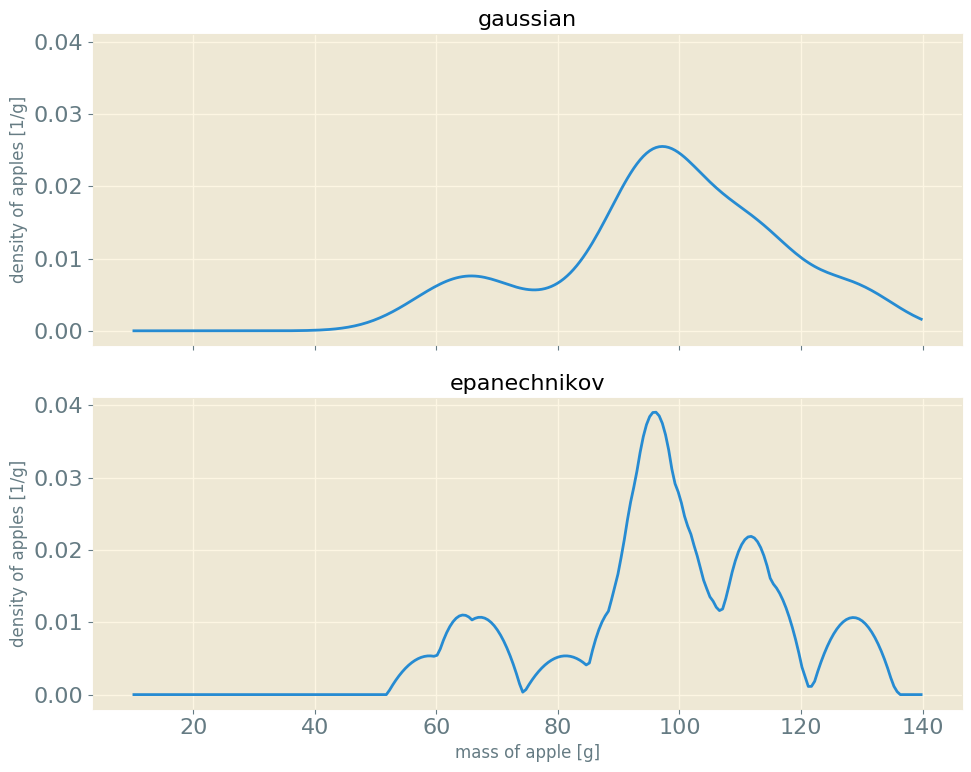

PyObject Text(0.5, 28.000000000000007, 'mass of apple [g]')

In [29]:
# define apple masses at which we want to estimate the density
masses = range(10.0, stop=140.0, length=250)

# do the KDE
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for (i, wut_kernel) in enumerate(["gaussian", "epanechnikov"])
    # do KDE with this kernel
    ρ = [corys_kde(mass, df[:, :mass], λ, wut_kernel) for mass in masses]
    # plot estimated densities vs. masses
    axs[i].plot(masses, ρ)
    axs[i].set_ylabel("density of apples [1/g]")
    axs[i].set_title(wut_kernel)
end
xlabel("mass of apple [g]")

## scikit-learn for KDE

how to import scikit-learn functions (scikit-learn is a Python library) into Julia.

In [30]:
@sk_import neighbors.kde : KernelDensity

PyObject <class 'sklearn.neighbors.kde.KernelDensity'>

e.g. let's do a Gaussian kernel density estimation to estimate the density at 100 g.

In [31]:
kde = KernelDensity(kernel="gaussian", bandwidth=λ)
sample_masses = [[row[:mass]] for row in eachrow(df)]

20-element Array{Array{Float64,1},1}:
 [108.20535675585407]
 [92.11445827312127] 
 [107.95894817321351]
 [58.87711063761283] 
 [100.10360270241122]
 [67.44315510523454] 
 [92.14622115463766] 
 [129.096902994266]  
 [96.72133629711364] 
 [66.9553570753678]  
 [99.59985147205123] 
 [128.11149783031908]
 [97.20868238556788] 
 [81.27085357175854] 
 [98.01357496629956] 
 [113.1726581261136] 
 [91.82359854827018] 
 [95.53643088149084] 
 [114.20489522388259]
 [114.88416683301007]

In [32]:
kde.fit(sample_masses)
exp.(kde.score_samples([[100.0]]))

1-element Array{Float64,1}:
 0.02456535050132132

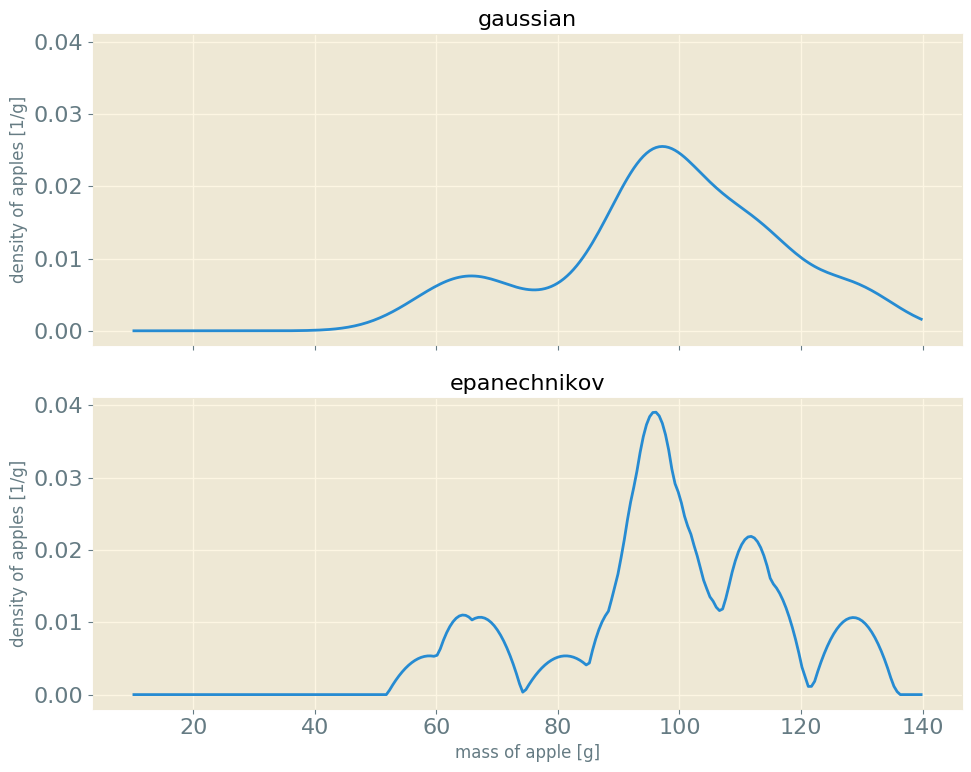

PyObject Text(0.5, 28.000000000000007, 'mass of apple [g]')

In [33]:
# do the KDE
fig, axs = subplots(2, 1, figsize=(10, 8), 
                    sharex=true, sharey=true, tight_layout=true)

for (i, wut_kernel) in enumerate(["gaussian", "epanechnikov"])
    #
    # use scikit-learn for KDE
    #
    # construct KernelDenstiy object. tell it kernl and bandwidth to use
    kde = KernelDensity(kernel=wut_kernel, bandwidth=λ)
    # write sample as an array of arrays (to accommodate format of higher dimensional data)
    sample_masses = [[row[:mass]] for row in eachrow(df)]
    # pass the KernelDensity object the data, "fit"
    kde.fit(sample_masses)
    # estimate the denstiy at our specified `masses`. 
    # this returns the log of the density so need to exponentiate
    ρ = exp.(kde.score_samples([[mass] for mass in masses]))
    
    # plot estimated densities vs. masses
    axs[i].plot(masses, ρ)
    axs[i].set_ylabel("density of apples [1/g]")
    axs[i].set_title(wut_kernel)
end
xlabel("mass of apple [g]")

## using the estimated probability density
what is the probability that a randomly drawn apple from the orchard has a mass of less than 80 g?

\begin{equation}
\int_0^{80} f(x)dx
\end{equation}

In [44]:
dx = 0.01
cumulative_density = 0.0
mass = 0.0
while mass < 80.0
    cumulative_density += corys_kde(mass, df[:, :mass], λ, "gaussian") * dx
    mass += dx
end
cumulative_density

0.17627417251335278

## how to choose the bandwidth?
* bandwidth too large => oversmoothed density (smooth out most features of the data)
* bandwidth too small => undersmoothed density (you see features in your density estimate that are not truly present in the underlying distribution)

$\lambda=1.0$: bandwidth too small, see jagged features in the distribution that are [probably] not there<br>
$\lambda=15.0$: smooth out data to the extend that you don't see bimodality<br>
$\lambda=8.0$: just right, we see bimodality

there are several methods for choosing the bandwidths... we will do this in class later when we do cross-validation.

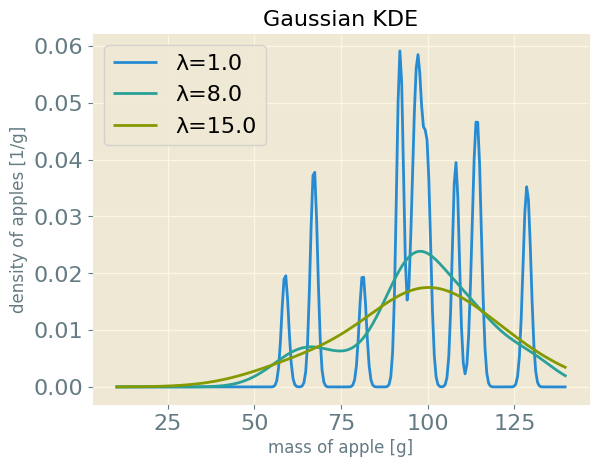

PyObject <matplotlib.legend.Legend object at 0x7f4511ed00f0>

In [35]:
λs = range(1.0, stop=15.0, length=3)
wut_kernel = "gaussian"

for λ in λs
    # do KDE with this kernel
    ρ = [corys_kde(mass, df[:, :mass], λ, wut_kernel) for mass in masses]
    # plot estimated densities vs. masses
    plot(masses, ρ, label="λ=$λ")
end
xlabel("mass of apple [g]")
title("Gaussian KDE")
ylabel("density of apples [1/g]")
legend()

## KDE in multiple dimensions

e.g. theft from vehicles in Vancouver, Canada. the raw data consist of geo-coordinates of theft from vehicles.

<img src="https://1.bp.blogspot.com/-8e1KvRfOJL4/Wf2YTkr4VrI/AAAAAAAAApo/6JtI6MOO7moJjdkkoz6ESl5PZTGKjg0OACLcBGAs/s1600/crime-heatmap-vancouver-color.png" width=500>